In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#!pip install yfinance
import yfinance as yf
import math

In [7]:
data=yf.download(tickers='EURUSD=X',start='2011-12-31',end='2019-12-31',interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [8]:
data_close = data.filter(['Close'])
dataset = data_close.values

In [9]:
train_len = math.ceil(len(dataset)*.8)

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
training_data = scaler.fit_transform(dataset[:train_len,:])

In [20]:
x_train = []
y_train = []
for i in range(60, len(training_data)):
    x_train.append(training_data[i-60:i,0])
    y_train.append(training_data[i,0])
x_train,y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.save('lstm_model.h5')

model.fit(x_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100


/Users/spencerandersen/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 2s 19ms/step - loss: 0.0246
Epoch 2/100
51/51 [==============================] - 1s 19ms/step - loss: 0.0039
Epoch 3/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0034
Epoch 4/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0032
Epoch 5/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0029
Epoch 6/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0029
Epoch 7/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0027
Epoch 8/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0026
Epoch 9/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0024
Epoch 10/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0022
Epoch 11/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0022
Epoch 12/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0020
Epoch 13/100
51/51 [=================

In [41]:
test_data = scaler.transform(dataset[train_len - 60:,:])
x_test = []
y_test = []
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    y_test.append(test_data[i,0])

x_test,y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

In [42]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions.shape

13/13 [==============================] - 0s 5ms/step


(416, 1)

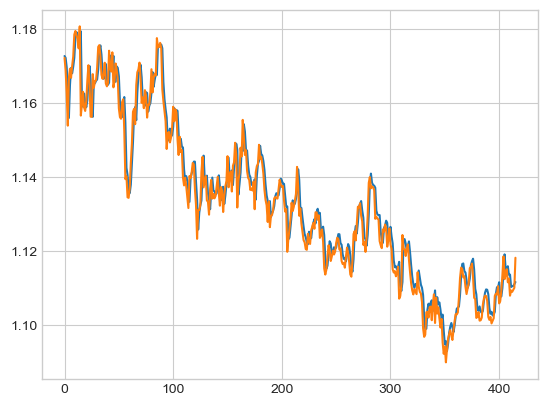

In [43]:
plt.plot(predictions)
plt.plot(y_test)

In [75]:
new = yf.download(tickers='EURUSD=X',start='2020-01-01',end='2020-05-05',interval='1d')
new = new.filter(['Close'])
new_dataset = new.values
new_data = scaler.transform(new_dataset)
test = []
new_y_test = []
for i in range(60,len(new_data)):
    test.append(new_data[i-60:i,0])
    new_y_test.append(new_data[i,0])
test = np.array(test)
new_y_test = np.array(new_y_test)
test = np.reshape(test, (test.shape[0],test.shape[1],1))
new_predictions = model.predict(test)
new_predictions = scaler.inverse_transform(new_predictions)
new_y_test = np.reshape(new_y_test, (new_y_test.shape[0],1))
new_y_test = scaler.inverse_transform(new_y_test)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 33ms/step


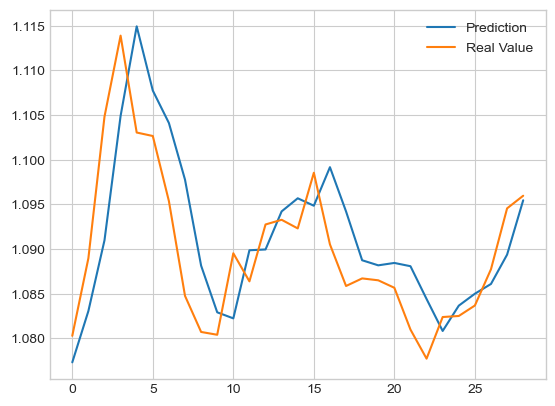

In [76]:
plt.plot(new_predictions)
plt.plot(new_y_test)
plt.legend(['Prediction', 'Real Value'])

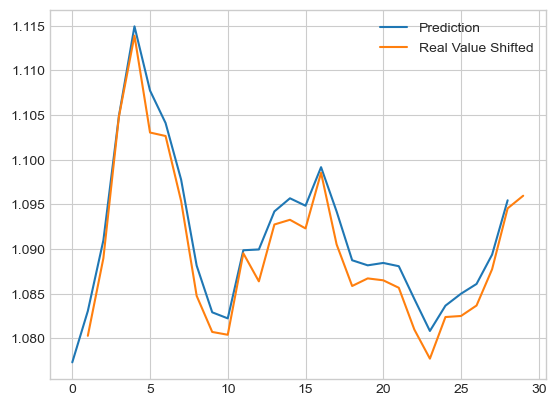

In [77]:
plt.plot(new_predictions)
plt.plot(range(1,1+len(new_y_test)),new_y_test)
plt.legend(['Prediction', 'Real Value Shifted'])

4.490768909454346 4.490768909454346


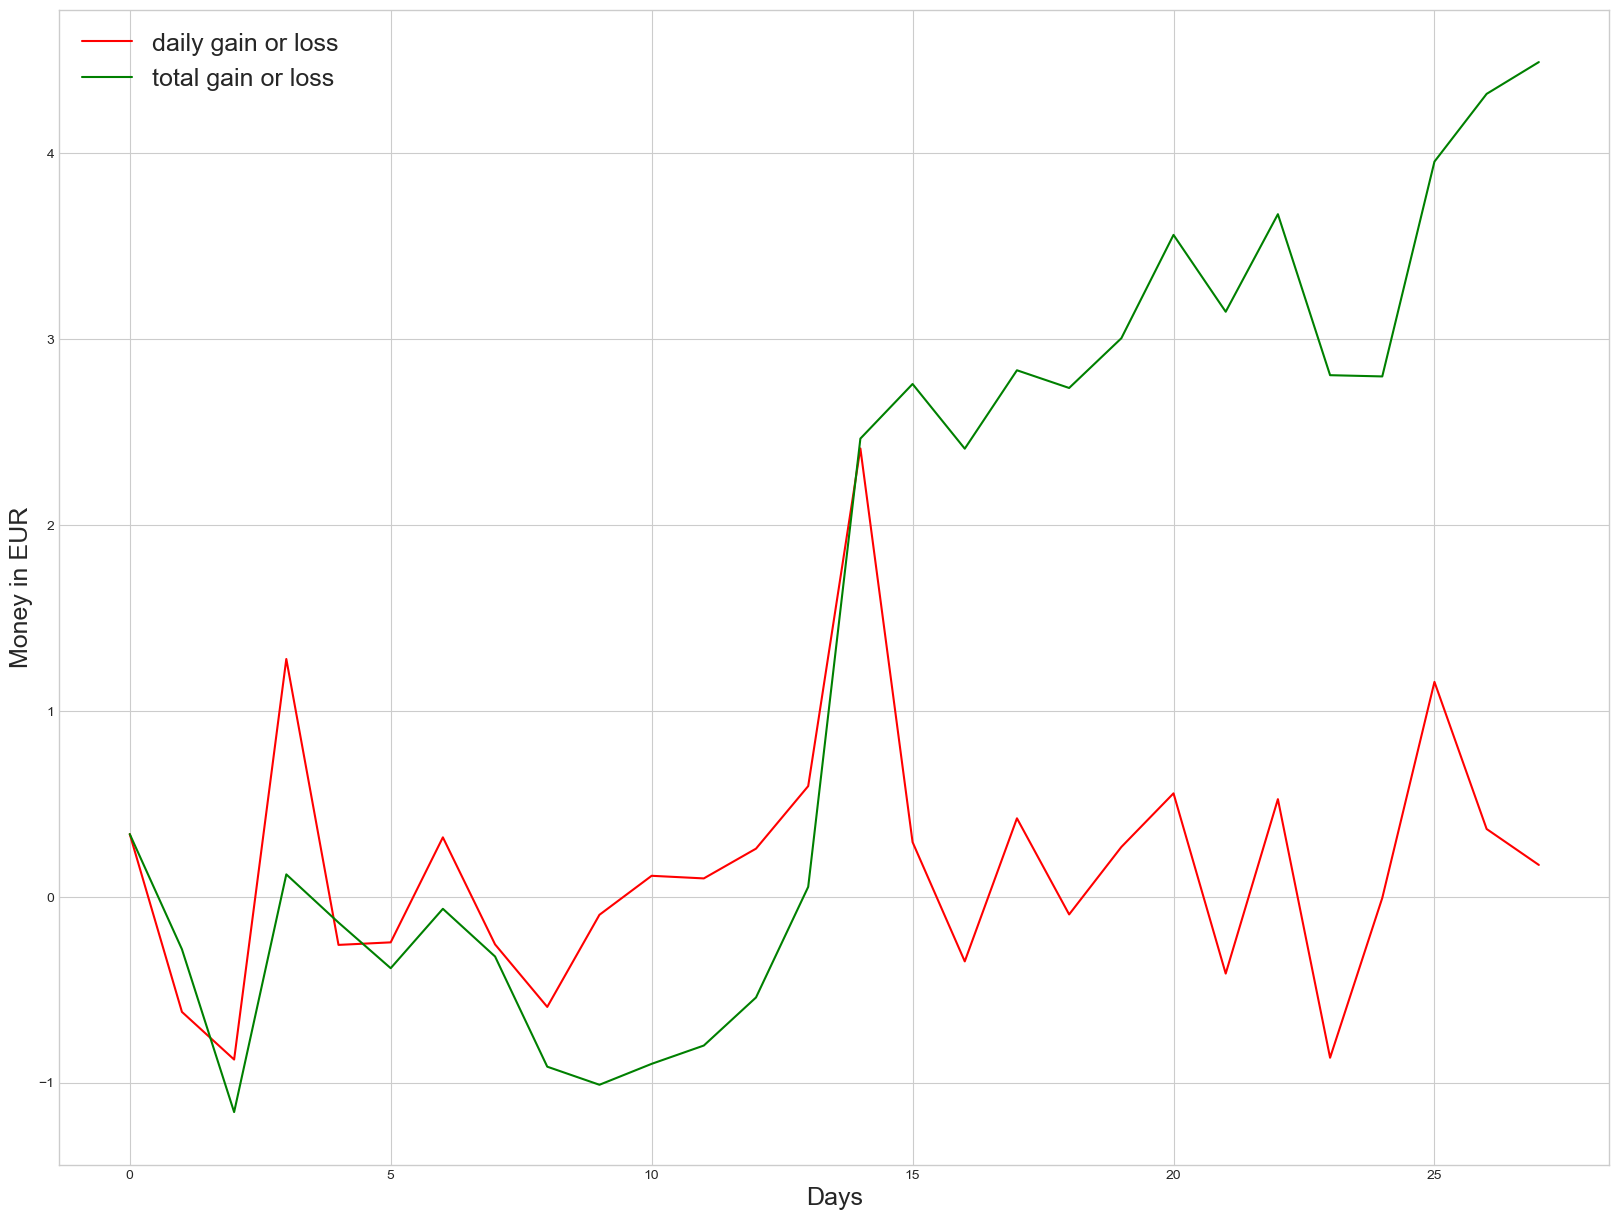

In [81]:
def buy_or_sell(close,pred,i):
    if pred[i+1] > close[i]:
        return True # Buy
    else:
        return False # Sell

def gain_loss(close,pred):
    total = []
    differ = []
    capital = 0
    for i in range(0,28): # forecasting 28 days
        diff = 100*(close[i+1,0]-close[i,0])
        if buy_or_sell(close,pred,i) == False:
            diff = -diff
        capital = capital + diff
        total.append(capital)
        differ.append(diff)
    print(sum(differ), capital)

    plt.figure(figsize=(20,15))
    plt.plot(differ,color = 'red')
    plt.plot(total,color = 'green')
    plt.legend(['daily gain or loss', 'total gain or loss'],fontsize = 18)
    plt.ylabel('Money in EUR', fontsize = 18)
    plt.xlabel('Days', fontsize = 18)
    plt.show

gain_loss(new_y_test,new_predictions)